### Time Series Classification
Notebook structure:
1. get labelled data from `binary_windows_labelling.py` - balance the data via undersampling of the non-event class
2. extract features via wavelet scattering transform - explore and visualize the features
3. define a classification model; split scattering coefficients into training and testing sets, use the first to train classification models and the second to evaluate them
4. compute confusion matrix
5. plot ROC curve and compute AUC
6. compare accuracy/ROC/AUC of different models
7. repeat the process with a limited amount of features (features selection via random forest Gini's importance) and compare results

In [7]:
import pandas as pd
import numpy as np
import os
import random
random.seed(2)
import torch
torch.manual_seed(2) 
from torch.nn import Linear, NLLLoss, LogSoftmax, Sequential
from torch.optim import Adam
from kymatio.torch import Scattering1D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Paths

In [14]:
event_path = 'labelled_data/event/'
non_event_path = 'labelled_data/non-events/'

In [15]:
# Undersampling the majority class:
# non-events class are significantly more, thus choose whether to sample non-events, and the dim of the sample
sample_non_ev = True
sample_n = len(os.listdir(event_path)) # 193 events, random sample same number of non-events
file_in_sample_path = 'labelled_data/selected_sample.txt' # save sample files used for reproducibility

#### Parameters

In [16]:
# SET PARAMS FOR THE SCATTERING TRANSFORM
# T = NUM OF SAMPLES, GIVEN BY THE SIZE OF THE INPUT
# 2**J = MAX SCALE OF WAVELET TRANSFORM, SPECIFIED AS A POWER OF 2
# Q = NUM OF WAVELETS PER OCTAVE (RESOLVE FREQ AT RESOLUTION 1/Q)

# set more appropriate values of parameters

T = 20*60 + 1 # 20 mins * 60 + 1 event timestamp
# J = 8
# Q = 12
J = 10 # J ->  1201 ~ 2**J  ->  J ~ log_2(1201) ~ 10.91 --> seems better 10 or 9
Q = 5 # seems like the best value is between 5-6 

In [17]:
# take a small constant to add to the scattering coefficients 
# before computing the log to avoid obtaining very large 
# values when the coeffs are close to zero
log_eps = 1e-6

#### Load the data

In [18]:
def fill_NaN(sequence_dataframe: pd.core.series.Series, filling_method: str) -> np.ndarray:
    '''
    Fill missing values in a time series 
    according to passed method (linear_interpolation or mean),
    and return the filled sequence as a numpy array.
    '''
    if filling_method == 'linear_interpolation': # linear interpolation
        sequence_dataframe = sequence_dataframe.interpolate(method='linear')
        # fill NaN at the beginning or end of the series, if any
        sequence_dataframe.ffill(inplace=True) # forward filling
        sequence_dataframe.bfill(inplace=True) # backward filling

    elif filling_method == 'mean':
        mean_value = sequence_dataframe.mean()
        sequence_dataframe = sequence_dataframe.fillna(mean_value) # mean 
    
    return np.array(sequence_dataframe)

NOTE: randomness: results will vary slightly depending on the sample of non-event picked; for reproducibility, at the first run, the selected sample is saved, and re-used in all subsequent runs.

In [19]:
# if I already extracted a sample, read it, else extract a sample and save it (for reproducibility)

if os.path.exists(file_in_sample_path):
    # if I already extracted a sample, read it
    all_seq_data_files = []
    with open(file_in_sample_path, "r") as file:
        for line in file:
            all_seq_data_files.append(line.strip())

else:
    # else, extract a sample
    # get all data files paths
    files_ev = [event_path + item for item in os.listdir(event_path)] 
    files_non_ev = [non_event_path + item for item in os.listdir(non_event_path)]

    if sample_non_ev == True:
        random_non_ev = random.sample(files_non_ev, sample_n)
        all_seq_data_files = files_ev + random_non_ev
    else:
        all_seq_data_files = files_ev + files_non_ev

    # shuffle the files 
    random.shuffle(all_seq_data_files)

    # save sampled used to use always the same in the following trials
    with open(file_in_sample_path, 'w') as file:
        for string in all_seq_data_files:
            file.write(string + '\n')

In [20]:
# initialize 2D tensors (each row is a different sequence)
num_seq = len(all_seq_data_files)
sequences = torch.zeros(num_seq, T, dtype=torch.float32)
labels = torch.zeros(num_seq, dtype=torch.int64)

lab_dict = {'event':1, 'non-event':0}

filling_method = 'linear_interpolation' 

i = 0 # row of sequences tensor to update
for e in all_seq_data_files:
    # get sequence
    df = pd.read_csv(e)
    seq = df.sort_values(by=['Date_UTC' if 'Date_UTC' in df.columns else 'Unnamed: 0']).dbn_nez

    # get label
    y = [lab_dict['non-event'] if 'non-event' in e else lab_dict['event']][0]
    
    # deal with NaN
    seq_filled = fill_NaN(seq, filling_method)

    # convert from np array to pytorch tensor
    seq_filled = torch.from_numpy(seq_filled)

    # comput columns from which to start filling
    starting_col_index = (T - seq_filled.numel()) // 2
    
    # add data to sequences tensor
    sequences[i,starting_col_index:starting_col_index + seq_filled.numel()] = seq_filled

    # update label
    labels[i] = y

    # update counter (next row)
    i += 1

In [21]:
np.isnan(sequences).any()

tensor(0, dtype=torch.uint8)

In [22]:
len(sequences), len(labels)

(386, 386)

#### Create Scattering1D obj. to calculate wavelets coefficients

Scattering1D is designed for 1D signals, such as time series data, and it is based on the concept of wavelet scattering (~convolution: convolve the input signal with a set of wavelet filters and then compute the modulus of the convolutions).  
This method can be used to extract features from the input signal in a hierarchical manner, capturing both low-level and high-level features. The extracted features are used to train binary classifiers, to identify whether they concern an "event" or "non-event".

In [23]:
scattering = Scattering1D(J, T, Q)

In [24]:
# compute scattering transform for all signals 
Sc_all = scattering.forward(sequences)
Sc_all = Sc_all[:,1:,:] # remove 0th order (low-pass filtered version of the signals, not carring meaningful info)

In [25]:
# take log (log-scatteing transform)
Sc_all = torch.log(torch.abs(Sc_all) + log_eps)

In [26]:
# average time dimension (last dim) to get time-shift invariant representation
Sc_all = torch.mean(Sc_all, dim=-1) # equivalent to Global Avg Pooling 

In [27]:
len(sequences[0]), len(Sc_all[0])

(1201, 235)

In [28]:
np.shape(Sc_all) # shape (num_obs, num_feats)

torch.Size([386, 235])

In [29]:
np.isnan(Sc_all).any()

tensor(0, dtype=torch.uint8)

#### Visualize features extracted

In [38]:
feat1 = Sc_all[:,0] # first feature

In [39]:
feats_df = pd.DataFrame({'feature_1':Sc_all[:,0], 'feature_2':Sc_all[:,1], 'feature_3':Sc_all[:,2], 
                         'feature_3rdlast':Sc_all[:,-3], 'feature_2ndlast':Sc_all[:,-2], 'feature_last':Sc_all[:,-1], 
                         'label':labels})

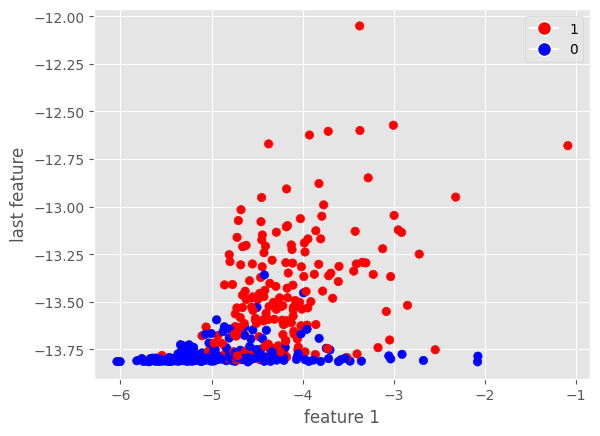

In [40]:
plt.scatter(feats_df['feature_1'], feats_df['feature_last'], c=feats_df['label'].map({1: 'red', 0: 'blue'}))

plt.xlabel('feature 1')
plt.ylabel('last feature')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

plt.show()

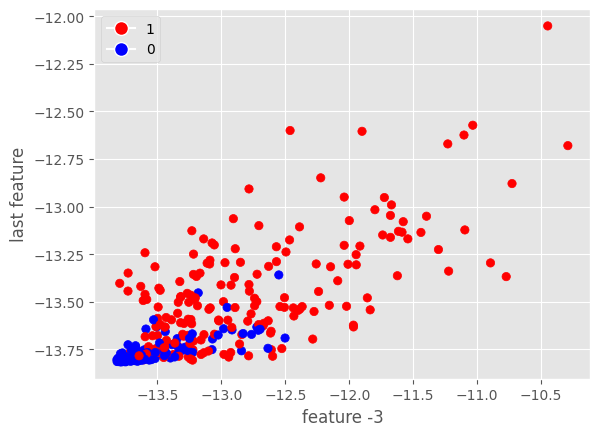

In [41]:
plt.scatter(feats_df['feature_3rdlast'], feats_df['feature_last'], c=feats_df['label'].map({1: 'red', 0: 'blue'}))

plt.xlabel('feature -3')
plt.ylabel('last feature')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

plt.show()

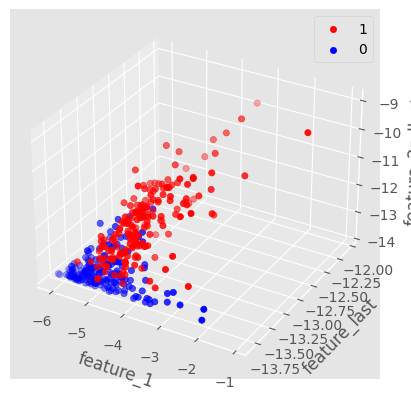

In [42]:
# columns
feat_discriminante = 'feature_1'
feat_y = 'feature_last'
feat_z = 'feature_2ndlast'
label = 'label'


# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = {1: 'red', 0: 'blue'}

for label_name, label_color in colors.items():
    subset = feats_df[feats_df[label] == label_name]
    ax.scatter(subset[feat_discriminante], subset[feat_y], subset[feat_z], c=label_color, label=label_name)

ax.set_xlabel(feat_discriminante)
ax.set_ylabel(feat_y)
ax.set_zlabel(feat_z)

ax.legend()

plt.show()


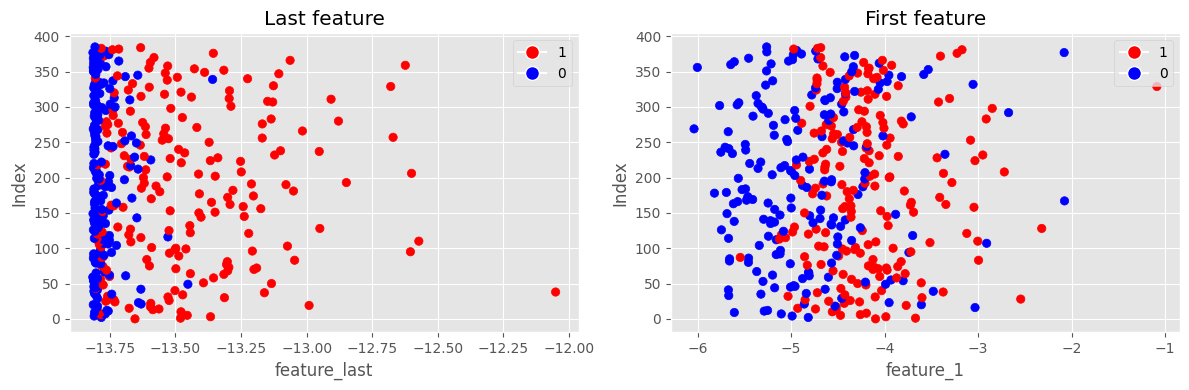

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  

# last feature
axes[0].scatter(feats_df['feature_last'], range(len(feats_df)), c=feats_df['label'].map({1: 'red', 0: 'blue'}))
axes[0].set_xlabel('feature_last')
axes[0].set_ylabel('Index')
axes[0].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

axes[0].set_title('Last feature')

# first feature 
axes[1].scatter(feats_df['feature_1'], range(len(feats_df)), c=feats_df['label'].map({1: 'red', 0: 'blue'}))
axes[1].set_xlabel('feature_1')
axes[1].set_ylabel('Index')
axes[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

axes[1].set_title('First feature')

plt.tight_layout()

plt.show()

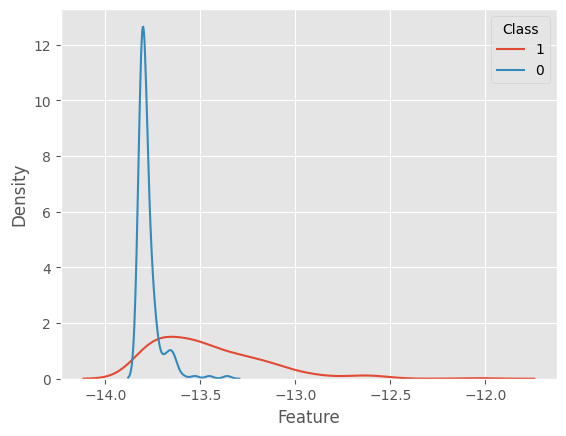

In [44]:
feature = 'feature_last'

for label_name in feats_df['label'].unique():
    subset = feats_df[feats_df[label] == label_name]
    sns.kdeplot(subset[feature], label=label_name)

plt.xlabel('Feature')
plt.ylabel('Density')
plt.legend(title='Class')

plt.show()

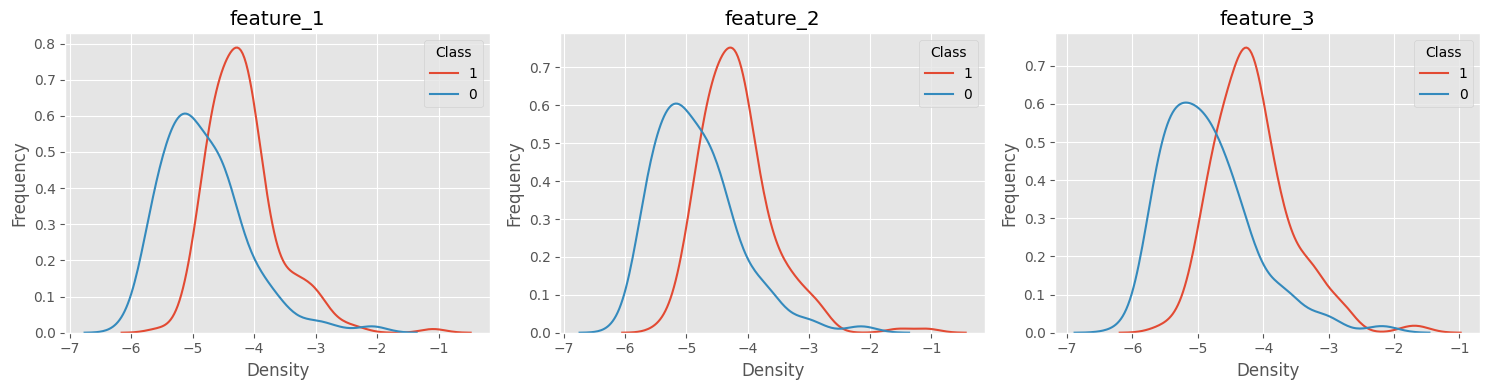

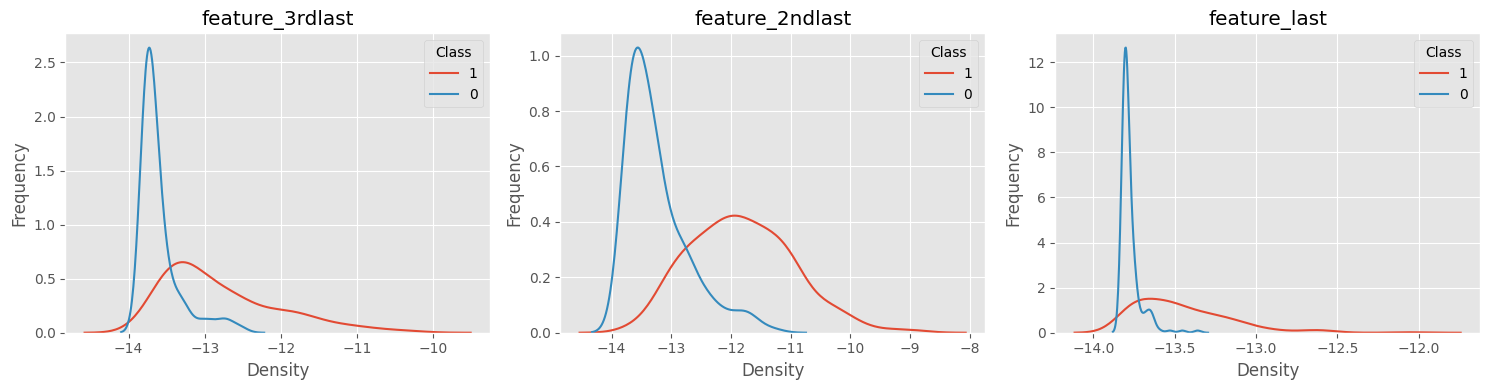

In [45]:
def plot_density(features):
    fig, axes = plt.subplots(1, len(features), figsize=(15, 4))  

    for i, feature in enumerate(features):
        for label_name in feats_df['label'].unique():
            subset = feats_df[feats_df['label'] == label_name]
            sns.kdeplot(subset[feature], label=label_name, ax=axes[i])

        axes[i].set_xlabel('Density')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(feature)

    for ax in axes:
        ax.legend(title='Class')

    plt.tight_layout()
    plt.show()

plot_density(['feature_1', 'feature_2', 'feature_3'])
plot_density(['feature_3rdlast', 'feature_2ndlast', 'feature_last'])

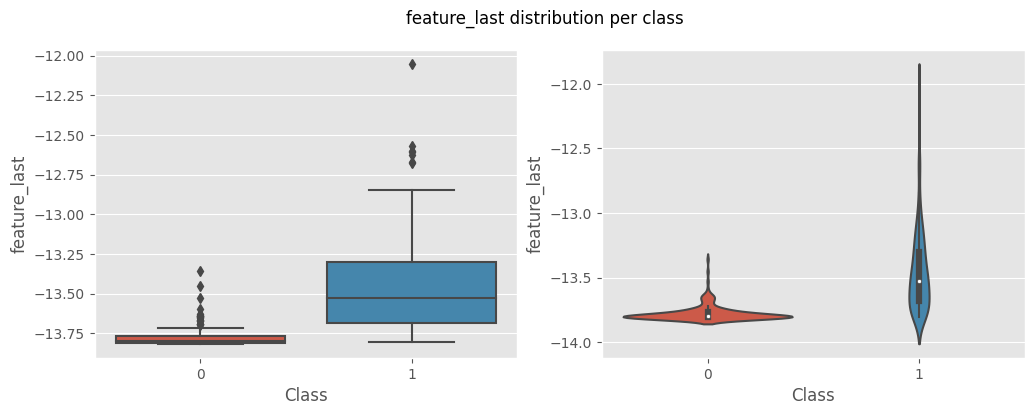

In [46]:
# feature to display
feature = 'feature_last'

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  

sns.boxplot(x='label', y=feature, data=feats_df, ax=axes[0])
axes[0].set_xlabel('Class')
axes[0].set_ylabel(feature)

sns.violinplot(x='label', y=feature, data=feats_df, ax=axes[1])
axes[1].set_xlabel('Class')
axes[1].set_ylabel(feature)

plt.suptitle(feature+' distribution per class')
plt.show()


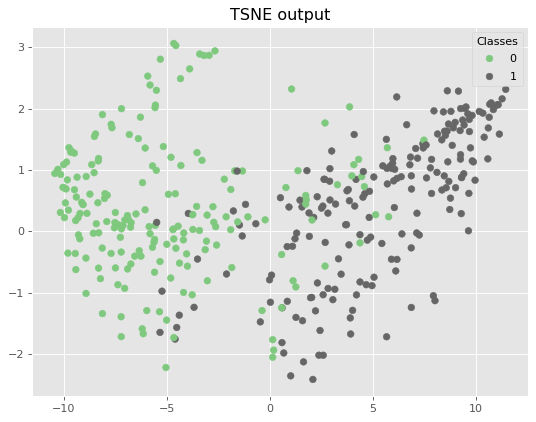

In [47]:
# project coefficients down to 2D using t-SNE and plot
coeffs_embedded = TSNE(n_components=2, perplexity=90, random_state=40).fit_transform(Sc_all)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

scatter = plt.scatter(coeffs_embedded[:, 0], coeffs_embedded[:, 1], label=labels, c=labels, cmap='Accent')
handles_scatter, labels_scatter = scatter.legend_elements()
legend = plt.legend(handles_scatter, labels_scatter, title='Classes')

plt.title('TSNE output')
plt.show()

In [48]:
print(np.shape(Sc_all)[1], 'features')

235 features


Explained variation per principal component: [0.86580235 0.04630787 0.01386193]


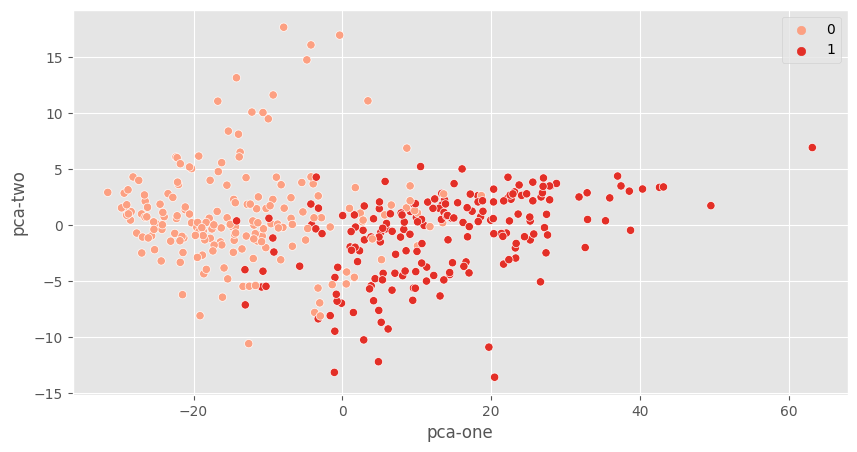

In [49]:
feats = pd.DataFrame(Sc_all)

# PCA 
pca = PCA(n_components=3) # 3 PC
pca_result = pca.fit_transform(feats) 

# put PC in feats_df 
feats['pca-one'] = pca_result[:,0]
feats['pca-two'] = pca_result[:,1] 
feats['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# plot scatterplot of first PC on x axis and second PC on y axis
plt.figure(figsize=(10,5))
sns.scatterplot( 
    x='pca-one', 
    y='pca-two',
    hue=labels, 
    palette=sns.color_palette('Reds', 2),
    data=feats,
    legend='full')
plt.show()

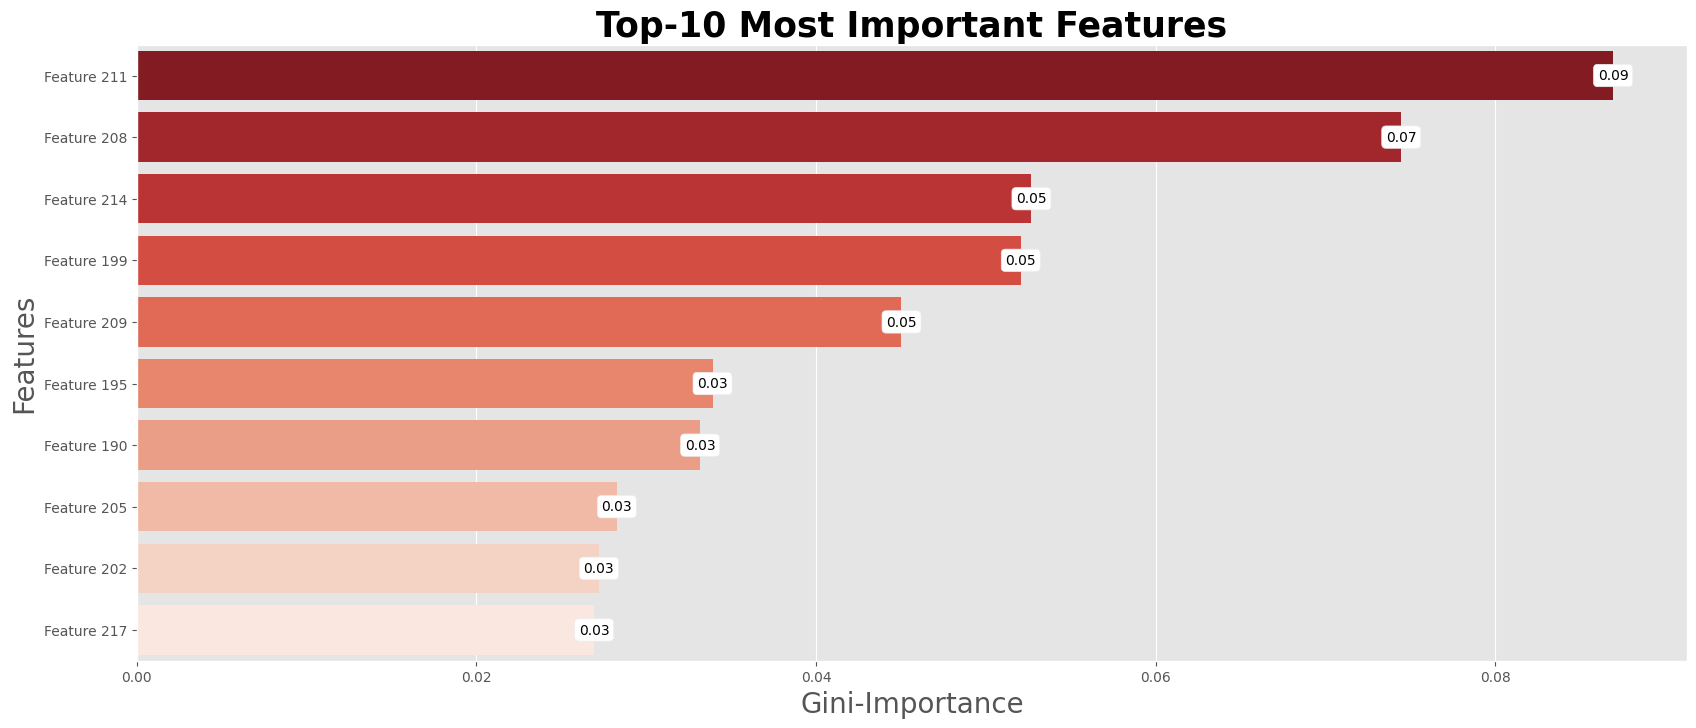

In [50]:
Sc_all_df = pd.DataFrame(Sc_all)

rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(Sc_all_df, labels)

# check which features are the most important in the random forest model
feats = {}
for feature, importance in zip(Sc_all_df.columns, rf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})


# Plot most important features
top_10 = importances[:10]
top_10['Features'] = top_10.Features.astype('str')
top_10['Features'] = ['Feature '+f for f in top_10.Features]

plt.figure(figsize=(20,8))
sns.barplot(x=top_10['Gini-Importance'], y=top_10['Features'], data=top_10,  palette='Reds_r')
plt.xlabel('Gini-Importance', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('Top-10 Most Important Features', fontsize=25, weight = 'bold')

i=1
for p in top_10['Gini-Importance']:
    x = p
    y = i-1
    lab = round(p, 2)
    plt.annotate(lab, (x,y), 
                bbox=dict(boxstyle='round', fc='w'), 
                va='center', ha='center')
    i+=1

plt.show()

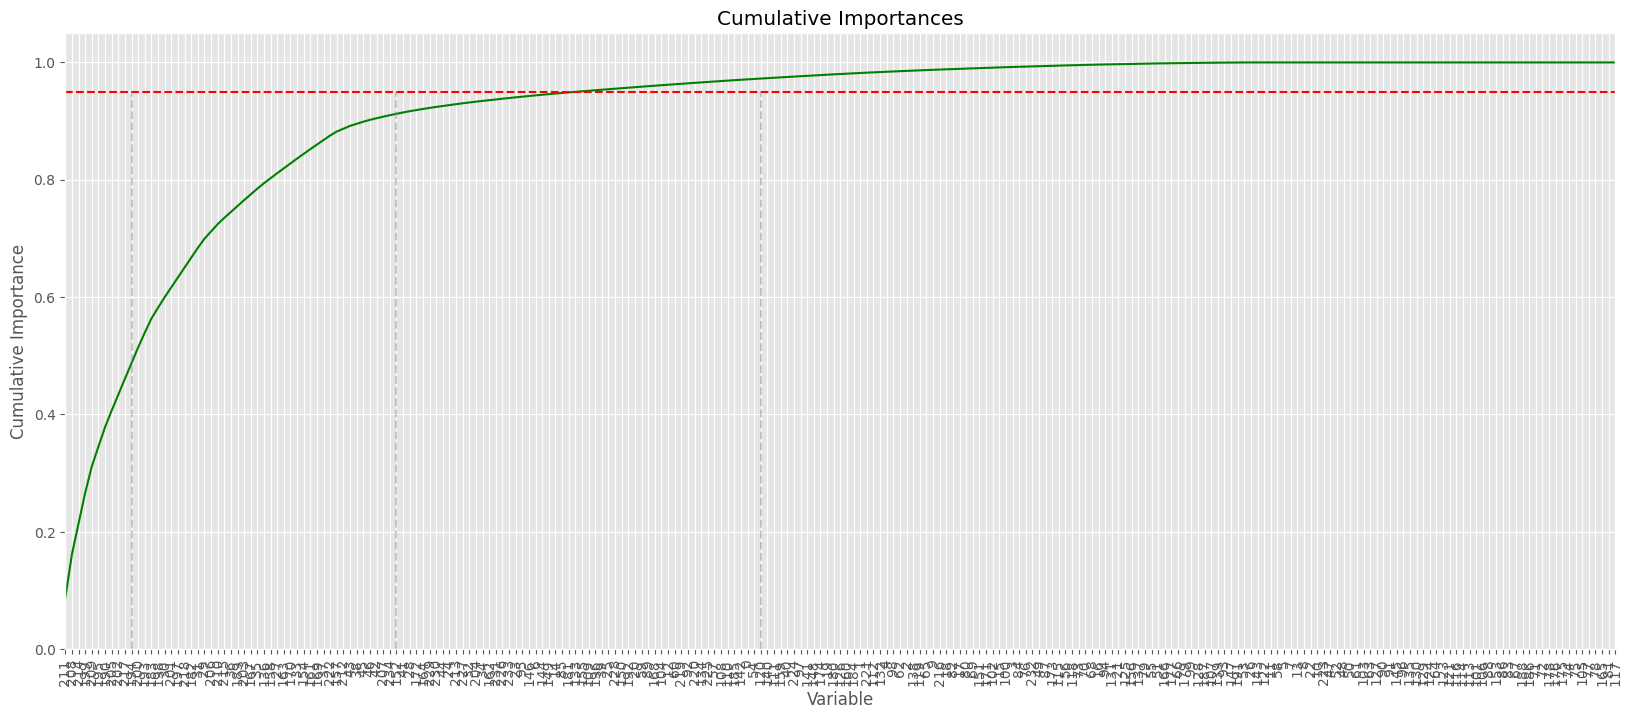

In [51]:
# cumulative importance
cumulative_importances = np.cumsum(importances['Gini-Importance'])

plt.figure(figsize=(20,8))

plt.plot(Sc_all_df.columns, cumulative_importances, 'g-')

# draw line at 95% of importance:
plt.hlines(y = 0.95, xmin=0, xmax=len(importances['Features']), color='r', linestyles='dashed')

# top 10 feats
plt.vlines(x=10, ymin=0, ymax=.95, color='gray', linestyles='dashed', alpha=0.4)

plt.vlines(x=50, ymin=0, ymax=.95, color='gray', linestyles='dashed', alpha=0.4)
plt.vlines(x=105, ymin=0, ymax=.95, color='gray', linestyles='dashed', alpha=0.4)

plt.xticks(Sc_all_df.columns, importances['Features'], rotation = 'vertical')
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances')

plt.xlim(xmin=0, xmax=len(importances['Features']) - 1)
plt.ylim(ymin=0)

plt.show()

can reach 95% of cumulative importance with approximately half the features, and most features torwards the end do not add any significant information

In [52]:
top_10_feats = [int(el.split()[1]) for el in top_10.Features.to_list()]

Sc_top_10 = Sc_all_df[top_10_feats]
Sc_top_10['label'] = labels

[f'corr feat_{i} - label: '+str(round(np.corrcoef(Sc_top_10[i], Sc_top_10['label'])[0,1], 3)) for i in top_10_feats]

['corr feat_211 - label: 0.802',
 'corr feat_208 - label: 0.8',
 'corr feat_214 - label: 0.798',
 'corr feat_199 - label: 0.778',
 'corr feat_209 - label: 0.78',
 'corr feat_195 - label: 0.77',
 'corr feat_190 - label: 0.762',
 'corr feat_205 - label: 0.805',
 'corr feat_202 - label: 0.786',
 'corr feat_217 - label: 0.789']

Get features that alone with which reaching 95% importance and drop others

In [53]:
importances['Cumulative-Importance'] = importances['Gini-Importance'].cumsum()
importances

,Features,Gini-Importance,Cumulative-Importance
0,211,0.086942,0.086942
1,208,0.074464,0.161406
2,214,0.052683,0.214089
3,199,0.052055,0.266144
4,209,0.045031,0.311176
...,...,...,...
230,77,0.000000,1.000000
231,78,0.000000,1.000000
232,165,0.000000,1.000000
233,81,0.000000,1.000000


In [54]:
# find the index where cumulative importance first reaches or exceeds 0.95
index_to_cut = importances[importances['Cumulative-Importance'] >= 0.95].index[0]

cut_importances = importances.iloc[:index_to_cut + 1]
cut_importances

,Features,Gini-Importance,Cumulative-Importance
0,211,0.086942,0.086942
1,208,0.074464,0.161406
2,214,0.052683,0.214089
3,199,0.052055,0.266144
4,209,0.045031,0.311176
...,...,...,...
74,14,0.000982,0.947024
75,85,0.000957,0.947981
76,181,0.000949,0.948930
77,133,0.000939,0.949869


In [55]:
col_impo_feats = cut_importances.Features.to_list()
reduced_Sc_all = Sc_all[:, col_impo_feats]
reduced_Sc_all # Sc_all with only most importance features according to Gini-Importance

tensor([[ -9.3414,  -9.3468,  -9.2967,  ...,  -8.2846,  -8.9092,  -7.5391],
        [ -9.8507, -10.7105,  -9.8845,  ...,  -9.2103, -10.0585,  -8.5316],
        [-12.1464, -12.2476, -12.0891,  ..., -10.5321, -12.3490,  -9.7178],
        ...,
        [-12.1662, -12.4118, -12.2608,  ..., -10.7423, -11.6942, -10.1115],
        [-10.7740, -10.6645, -10.8425,  ...,  -9.2932,  -9.8838,  -8.5944],
        [-11.9693, -12.1485, -11.7510,  ..., -10.8745, -11.7972, -10.4580]])

In [56]:
np.shape(reduced_Sc_all), np.shape(Sc_all)

(torch.Size([386, 79]), torch.Size([386, 235]))

#### Train classifier using wavelets coefficients (all features)

#### Split train and test set

In [57]:
X_train, X_test, y_train, y_test = train_test_split(Sc_all, labels, test_size=0.3, shuffle=True, random_state=2)

In [58]:
# standardize data using training mean and variance
mu_train = X_train.mean(dim=0)
std_train = X_train.std(dim=0)

Sx_train = (X_train - mu_train) / std_train
Sx_test = (X_test - mu_train) / std_train

#### Define logistic regression model

In [59]:
num_input = Sx_train.shape[-1]
num_classes = y_train.unique().numel()

# fully connected linear layer + log softmax
model = Sequential(Linear(num_input, num_classes), LogSoftmax(dim=1))
optimizer = Adam(model.parameters())
criterion = NLLLoss() # negative log likelihood loss

#### model parameters

In [60]:
batch_size = 32 # number of signals to use in each gradient descent step
num_epochs = 50
lr = 1e-4

In [61]:
# total num of batches
n_samples = Sx_train.shape[0]
n_batches = n_samples // batch_size

#### training

In [62]:
for e in range(num_epochs):
    # random permutation
    perm = torch.randperm(n_samples)

    # for each batch, compute gradient wrt loss
    for i in range(n_batches):
        idx = perm[i * batch_size : (i+1) * batch_size]
        model.zero_grad()
        resp = model.forward(Sx_train[idx])
        loss = criterion(resp, y_train[idx])
        loss.backward()
        # take one step / update weights
        optimizer.step()

    
    resp = model.forward(Sx_train)
    avg_loss = criterion(resp, y_train)

    # predict training set classes to compute accuracy while training
    y_hat = resp.argmax(dim=1)
    accuracy = (y_train == y_hat).float().mean()

    print('Epoch {}, average loss = {:1.3f}, accuracy = {:1.3f}'.format(e, avg_loss, accuracy))

Epoch 0, average loss = 0.321, accuracy = 0.859
Epoch 1, average loss = 0.325, accuracy = 0.859
Epoch 2, average loss = 0.318, accuracy = 0.856
Epoch 3, average loss = 0.305, accuracy = 0.870
Epoch 4, average loss = 0.292, accuracy = 0.878
Epoch 5, average loss = 0.285, accuracy = 0.885
Epoch 6, average loss = 0.283, accuracy = 0.881
Epoch 7, average loss = 0.279, accuracy = 0.881
Epoch 8, average loss = 0.275, accuracy = 0.881
Epoch 9, average loss = 0.273, accuracy = 0.881
Epoch 10, average loss = 0.271, accuracy = 0.881
Epoch 11, average loss = 0.268, accuracy = 0.881
Epoch 12, average loss = 0.265, accuracy = 0.881
Epoch 13, average loss = 0.263, accuracy = 0.881
Epoch 14, average loss = 0.261, accuracy = 0.881
Epoch 15, average loss = 0.258, accuracy = 0.881
Epoch 16, average loss = 0.256, accuracy = 0.881
Epoch 17, average loss = 0.254, accuracy = 0.881
Epoch 18, average loss = 0.251, accuracy = 0.885
Epoch 19, average loss = 0.249, accuracy = 0.885
Epoch 20, average loss = 0.247

#### Evaluate on test set

In [63]:
resp = model.forward(Sx_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('TESTING: neg. ll loss = {:1.3f}, accuracy = {:1.3f}'.format(avg_loss, acc))

TESTING: neg. ll loss = 0.170, accuracy = 0.948


#### compute probabilities of class-assignemnt

In [64]:
# apply your trained model to test data to get probability estimates for each class 
model.eval() 
with torch.no_grad():
    logits = model(Sx_test)
    probs = torch.softmax(logits, dim=1)  # softmax to convert the model's output into probabilities

probs

tensor([[9.8644e-01, 1.3556e-02],
        [9.6464e-01, 3.5360e-02],
        [1.5190e-01, 8.4810e-01],
        [8.7026e-01, 1.2974e-01],
        [8.7109e-02, 9.1289e-01],
        [9.7345e-01, 2.6551e-02],
        [9.7467e-01, 2.5333e-02],
        [7.6643e-01, 2.3357e-01],
        [6.0125e-03, 9.9399e-01],
        [4.1995e-03, 9.9580e-01],
        [9.9906e-01, 9.4468e-04],
        [9.0548e-01, 9.4520e-02],
        [3.6720e-01, 6.3280e-01],
        [1.0309e-01, 8.9691e-01],
        [9.9664e-01, 3.3629e-03],
        [9.7334e-01, 2.6656e-02],
        [2.9492e-02, 9.7051e-01],
        [9.7284e-01, 2.7155e-02],
        [9.9780e-01, 2.2045e-03],
        [9.3959e-01, 6.0412e-02],
        [9.7958e-01, 2.0417e-02],
        [4.1120e-01, 5.8880e-01],
        [9.4493e-01, 5.5074e-02],
        [8.0735e-03, 9.9193e-01],
        [8.8848e-02, 9.1115e-01],
        [2.1151e-01, 7.8849e-01],
        [2.6074e-01, 7.3926e-01],
        [8.6715e-01, 1.3285e-01],
        [3.6396e-02, 9.6360e-01],
        [9.395

#### confusion matrix

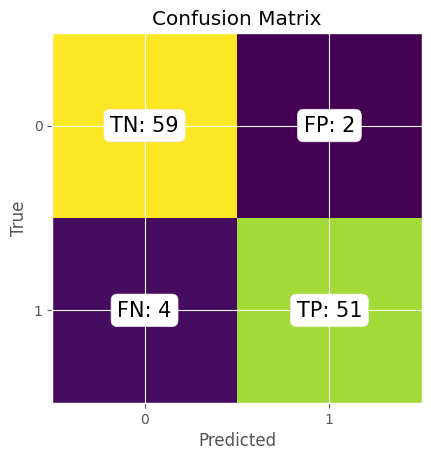

In [65]:
# confusion matrix

preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

plt.figure()
plt.imshow(confusion, cmap='viridis') 

tick_locs = np.arange(2)
ticks = ['{}'.format(i) for i in range(0, 2)]

plt.xticks(tick_locs, ticks)
plt.yticks(tick_locs, ticks)

plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(2):
    for j in range(2):

        if i == 0 and j == 0:
            lab = 'TN: '
        elif i == 0 and j == 1:
            lab = 'FP: '
        elif i == 1 and j == 0:
            lab = 'FN: '
        else:
            lab = 'TP: '


        plt.text(j, i, lab+str(confusion[i, j]), ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle="round", fc="w"))

plt.title('Confusion Matrix')
plt.show()

#### ROC curve

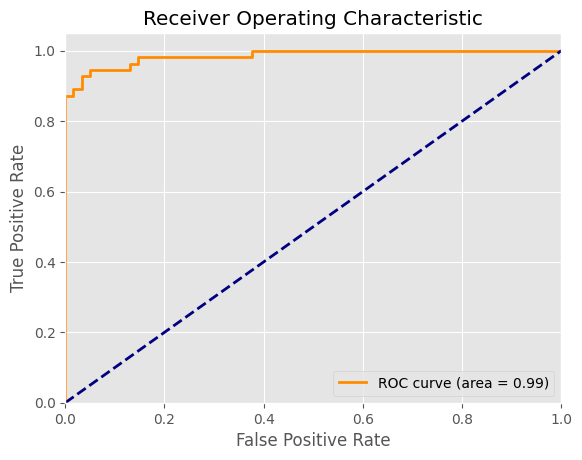

In [66]:
fpr, tpr, thresholds = roc_curve(true_test, probs[:, 1].numpy()) # probs positive outcome only

roc_auc = roc_auc_score(true_test, probs[:, 1].numpy())

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [67]:
# precision, recall, and F1-score
# NOTE: since the 'event' class is 'more important' to be predicted correctly,
# focus on recall rather than precision 


precision = precision_score(true_test, preds_test)

recall = recall_score(true_test, preds_test)

f1 = f1_score(true_test, preds_test)

tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

print('Precision: {:1.3f}\nRecall: {:1.3f}\nF1-score: {:1.3f}\nSpecificity: {:1.3f}'.format(precision, recall, f1, specificity))

Precision: 0.962
Recall: 0.927
F1-score: 0.944
Specificity: 0.967


Check predictions and prediction errors

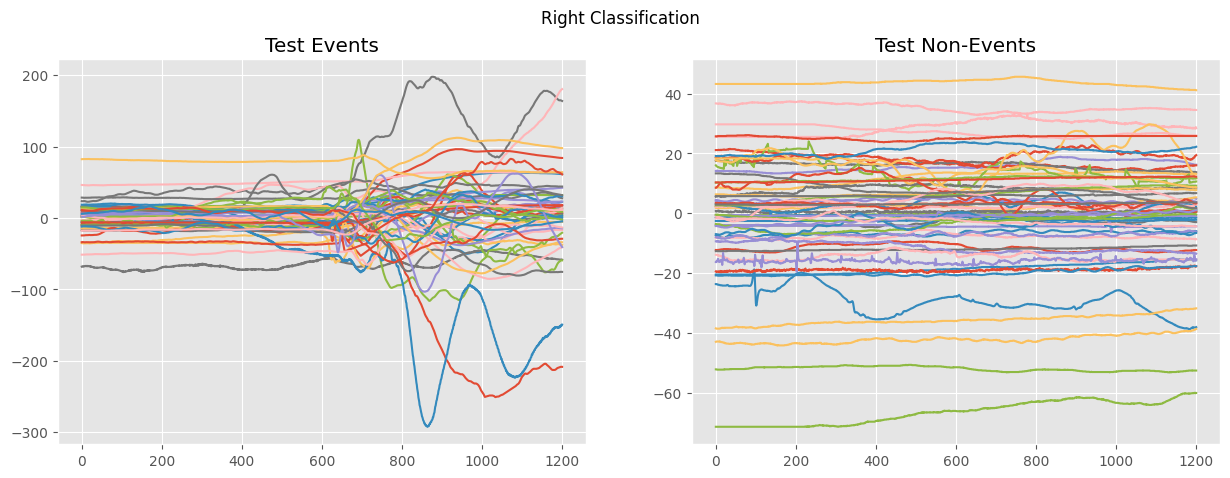

In [68]:
seq_train, seq_test, _, _ = train_test_split(sequences, labels, test_size=0.3, shuffle=True, random_state=2)
res_test = pd.DataFrame({'test_seq':[seq for seq in seq_test], 'true_lab':y_test, 'pred_lab':preds_test})

right_classif = res_test[res_test.true_lab == res_test.pred_lab]
zero_class = right_classif[right_classif.true_lab == 0]
one_class = right_classif[right_classif.true_lab == 1]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 

for ev in one_class.test_seq.to_list():
    ax1.plot(ev)
ax1.set_title('Test Events')

for non_ev in zero_class.test_seq.to_list():
    ax2.plot(non_ev)
ax2.set_title('Test Non-Events')

plt.suptitle('Right Classification')

plt.show()

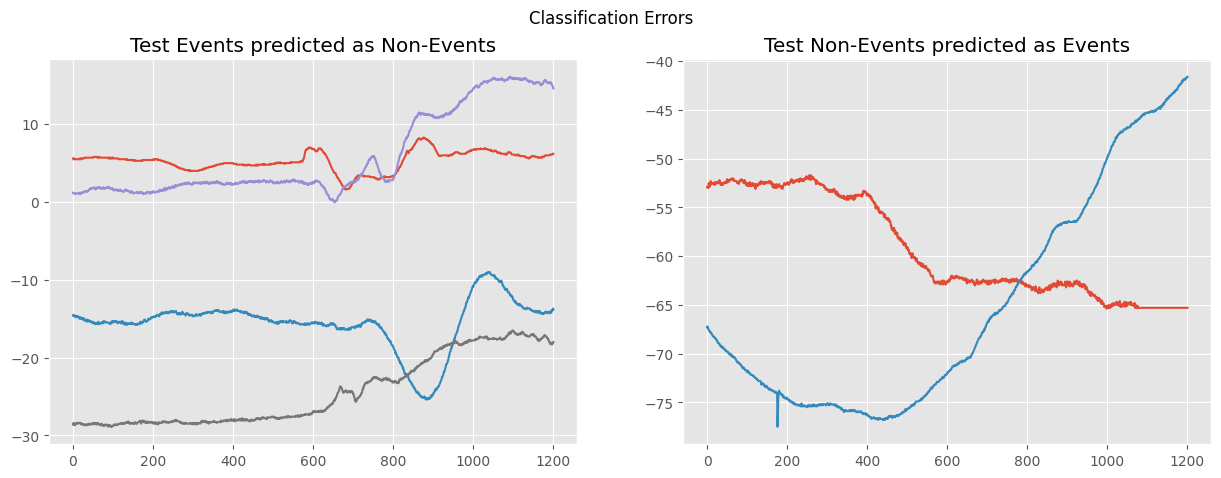

In [69]:
wrong_classif = res_test[res_test.true_lab != res_test.pred_lab]
zero_class = wrong_classif[wrong_classif.true_lab == 0]
one_class = wrong_classif[wrong_classif.true_lab == 1]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 

for ev in one_class.test_seq.to_list():
    ax1.plot(ev)
ax1.set_title('Test Events predicted as Non-Events')

for non_ev in zero_class.test_seq.to_list():
    ax2.plot(non_ev)
ax2.set_title('Test Non-Events predicted as Events')

plt.suptitle('Classification Errors')

plt.show()

______

#### Repeat training of the same model but using REDUCED features (cumulative gini-importance 95%)

In [70]:
# TRAIN WITH REDUCED FEATURES
X_train, X_test, y_train, y_test = train_test_split(reduced_Sc_all, labels, test_size=0.3, shuffle=True, random_state=2)

# standardize data using training mean and variance
mu_train = X_train.mean(dim=0)
std_train = X_train.std(dim=0)

Sx_train = (X_train - mu_train) / std_train
Sx_test = (X_test - mu_train) / std_train


# ------------------------------------------------

# shape
num_input = Sx_train.shape[-1]
num_classes = y_train.unique().numel()

# fully connected linear layer + log softmax
model = Sequential(Linear(num_input, num_classes), LogSoftmax(dim=1))
optimizer = Adam(model.parameters())
criterion = NLLLoss() # negative log likelihood loss

# total num of batches
n_samples = Sx_train.shape[0]
n_batches = n_samples // batch_size

# ------------------------------------------------

# TRAINING
for e in range(num_epochs):
    # random permutation
    perm = torch.randperm(n_samples)

    # for each batch, compute gradient wrt loss
    for i in range(n_batches):
        idx = perm[i * batch_size : (i+1) * batch_size]
        model.zero_grad()
        resp = model.forward(Sx_train[idx])
        loss = criterion(resp, y_train[idx])
        loss.backward()
        # take one step
        optimizer.step()

    
    resp = model.forward(Sx_train)
    avg_loss = criterion(resp, y_train)

    # predict training set classes to compute accuracy while training
    y_hat = resp.argmax(dim=1)
    accuracy = (y_train == y_hat).float().mean()

    print('Epoch {}, average loss = {:1.3f}, accuracy = {:1.3f}'.format(e, avg_loss, accuracy))

Epoch 0, average loss = 0.332, accuracy = 0.881
Epoch 1, average loss = 0.283, accuracy = 0.885
Epoch 2, average loss = 0.271, accuracy = 0.885
Epoch 3, average loss = 0.268, accuracy = 0.885
Epoch 4, average loss = 0.268, accuracy = 0.885
Epoch 5, average loss = 0.267, accuracy = 0.885
Epoch 6, average loss = 0.266, accuracy = 0.885
Epoch 7, average loss = 0.265, accuracy = 0.885
Epoch 8, average loss = 0.264, accuracy = 0.885
Epoch 9, average loss = 0.263, accuracy = 0.885
Epoch 10, average loss = 0.262, accuracy = 0.885
Epoch 11, average loss = 0.261, accuracy = 0.885
Epoch 12, average loss = 0.260, accuracy = 0.885
Epoch 13, average loss = 0.259, accuracy = 0.885
Epoch 14, average loss = 0.258, accuracy = 0.885
Epoch 15, average loss = 0.257, accuracy = 0.885
Epoch 16, average loss = 0.256, accuracy = 0.885
Epoch 17, average loss = 0.255, accuracy = 0.885
Epoch 18, average loss = 0.254, accuracy = 0.885
Epoch 19, average loss = 0.253, accuracy = 0.885
Epoch 20, average loss = 0.252

#### Evaluate on test set

In [71]:
resp = model.forward(Sx_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('TESTING: neg. ll loss = {:1.3f}, accuracy = {:1.3f}'.format(avg_loss, acc))

TESTING: neg. ll loss = 0.180, accuracy = 0.940


#### probabilities

In [72]:
# apply your trained model to test data to get probability estimates for each class 
model.eval() 
with torch.no_grad():
    logits = model(Sx_test)
    probs_reducted_feats = torch.softmax(logits, dim=1)  # softmax to convert the model's output into probabilities

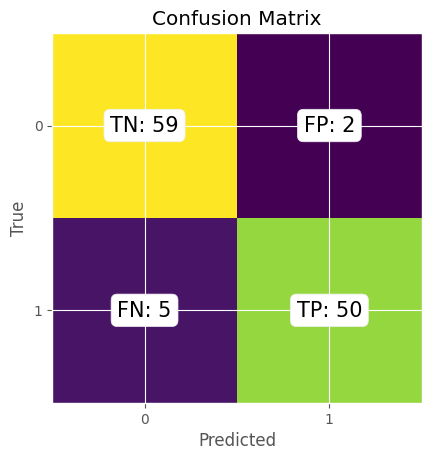

In [73]:
# confusion matrix

preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

plt.figure()
plt.imshow(confusion, cmap='viridis') 

tick_locs = np.arange(2)
ticks = ['{}'.format(i) for i in range(0, 2)]

plt.xticks(tick_locs, ticks)
plt.yticks(tick_locs, ticks)

plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(2):
    for j in range(2):

        if i == 0 and j == 0:
            lab = 'TN: '
        elif i == 0 and j == 1:
            lab = 'FP: '
        elif i == 1 and j == 0:
            lab = 'FN: '
        else:
            lab = 'TP: '


        plt.text(j, i, lab+str(confusion[i, j]), ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle="round", fc="w"))

plt.title('Confusion Matrix')
plt.show()

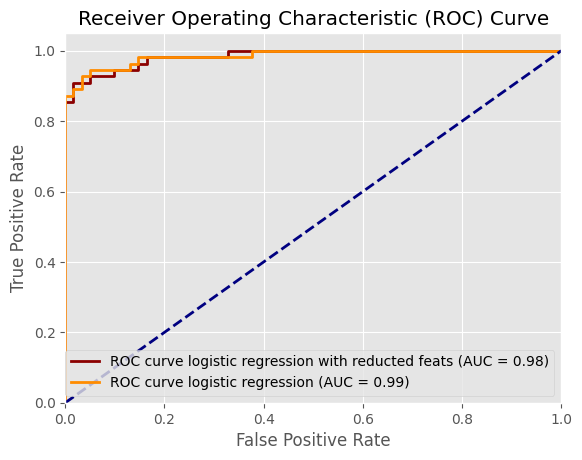

In [74]:
# ROC
fpr_reduced, tpr_reduced, thresholds_reduced = roc_curve(true_test, probs_reducted_feats[:, 1].numpy()) # probs positive outcome only
# AUC
auc_reduced = roc_auc_score(true_test, probs_reducted_feats[:, 1].numpy())


# plot ROC
plt.figure()

# logistic regression with reducted feats
plt.plot(fpr_reduced, tpr_reduced, color='darkred', lw=2, label=f'ROC curve logistic regression with reducted feats (AUC = {auc_reduced:.2f})')

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve logistic regression (AUC = {roc_auc:.2f})') # first logistic regression

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [75]:
precision = precision_score(true_test, preds_test)

recall = recall_score(true_test, preds_test)

f1 = f1_score(true_test, preds_test)

tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

print('Precision: {:1.3f}\nRecall: {:1.3f}\nF1-score: {:1.3f}\nSpecificity: {:1.3f}'.format(precision, recall, f1, specificity))

Precision: 0.962
Recall: 0.909
F1-score: 0.935
Specificity: 0.967


_______

### Define SVC model

In [76]:
'''X_train, X_test, y_train, y_test = train_test_split(reduced_Sc_all, labels, test_size=0.3, shuffle=True, random_state=2)

# standardize data using training mean and variance
mu_train = X_train.mean(dim=0)
std_train = X_train.std(dim=0)

Sx_train = (X_train - mu_train) / std_train
Sx_test = (X_test - mu_train) / std_train'''

'X_train, X_test, y_train, y_test = train_test_split(reduced_Sc_all, labels, test_size=0.3, shuffle=True, random_state=2)\n\n# standardize data using training mean and variance\nmu_train = X_train.mean(dim=0)\nstd_train = X_train.std(dim=0)\n\nSx_train = (X_train - mu_train) / std_train\nSx_test = (X_test - mu_train) / std_train'

In [77]:
np.isnan(Sx_train).any(), np.isnan(Sx_test).any()

(tensor(0, dtype=torch.uint8), tensor(0, dtype=torch.uint8))

In [78]:
# SVC parameters
param_grid = { 
        'C': [ 0.1,  1. , 10. ], # regularization
        'class_weight':[{1:2, 0:1},  # give weight 2 to class 1 (event)
                        {1:1, 0:.5}],
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'] # kernel coefficent for poly, rbf, sigmoid
        }
n_splits, n_repeats = 10, 5


# 10 folds CV
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2)
grid_search = GridSearchCV(estimator=SVC(), 
                            param_grid=param_grid, 
                            scoring='accuracy', 
                            refit='accuracy', 
                            n_jobs=-1, 
                            cv=cv)
gridCV = grid_search.fit(Sx_train, y_train)
gridCV.best_params_

{'C': 0.1, 'class_weight': {1: 2, 0: 1}, 'gamma': 'auto', 'kernel': 'sigmoid'}

In [79]:
svc = SVC(**gridCV.best_params_, probability=True).fit(Sx_train, y_train)

In [80]:
svm_preds = svc.predict(Sx_test)
confusion = confusion_matrix(y_test, svm_preds)
confusion

array([[54,  7],
       [ 4, 51]])

In [81]:
# probabilities class assignment
svc_probs = svc.predict_proba(Sx_test)
svc_probs

array([[0.96081685, 0.03918315],
       [0.95934903, 0.04065097],
       [0.28656091, 0.71343909],
       [0.92543237, 0.07456763],
       [0.10025358, 0.89974642],
       [0.95023561, 0.04976439],
       [0.96712445, 0.03287555],
       [0.88478584, 0.11521416],
       [0.01223744, 0.98776256],
       [0.00486233, 0.99513767],
       [0.99246772, 0.00753228],
       [0.90135569, 0.09864431],
       [0.39978188, 0.60021812],
       [0.19121189, 0.80878811],
       [0.98842103, 0.01157897],
       [0.96409934, 0.03590066],
       [0.03929631, 0.96070369],
       [0.95376305, 0.04623695],
       [0.98031056, 0.01968944],
       [0.95937719, 0.04062281],
       [0.96974596, 0.03025404],
       [0.51048541, 0.48951459],
       [0.88063995, 0.11936005],
       [0.01627198, 0.98372802],
       [0.0764323 , 0.9235677 ],
       [0.17564526, 0.82435474],
       [0.17310559, 0.82689441],
       [0.82021924, 0.17978076],
       [0.05679394, 0.94320606],
       [0.94011085, 0.05988915],
       [0.

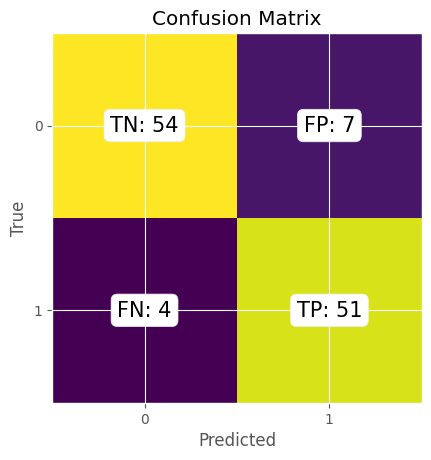

In [82]:
plt.figure()
plt.imshow(confusion, cmap='viridis') 

tick_locs = np.arange(2)
ticks = ['{}'.format(i) for i in range(0, 2)]

plt.xticks(tick_locs, ticks)
plt.yticks(tick_locs, ticks)

plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(2):
    for j in range(2):

        if i == 0 and j == 0:
            lab = 'TN: '
        elif i == 0 and j == 1:
            lab = 'FP: '
        elif i == 1 and j == 0:
            lab = 'FN: '
        else:
            lab = 'TP: '


        plt.text(j, i, lab+str(confusion[i, j]), ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle="round", fc="w"))

plt.title('Confusion Matrix')
plt.show()

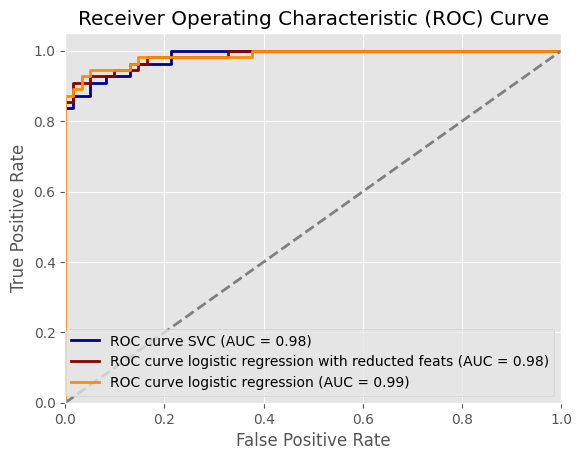

In [83]:
# ROC
fpr_svm, tpr_svm, thresholds = roc_curve(y_test, svc_probs[:, 1])

# AUC
roc_auc_svm = roc_auc_score(y_test, svc_probs[:, 1])


# plot ROC curve
plt.figure()
# SVC
plt.plot(fpr_svm, tpr_svm, color='darkblue', lw=2, label=f'ROC curve SVC (AUC = {roc_auc_svm:.2f})')

# logistic regression with reducted feats
plt.plot(fpr_reduced, tpr_reduced, color='darkred', lw=2, label=f'ROC curve logistic regression with reducted feats (AUC = {auc_reduced:.2f})')

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve logistic regression (AUC = {roc_auc:.2f})') # first logistic regression

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [84]:
accuracy_score(y_test, svm_preds)

0.9051724137931034

In [85]:
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        61
           1       0.88      0.93      0.90        55

    accuracy                           0.91       116
   macro avg       0.91      0.91      0.91       116
weighted avg       0.91      0.91      0.91       116



In [86]:
precision = precision_score(y_test, svm_preds)

recall = recall_score(y_test, svm_preds)

f1 = f1_score(y_test, svm_preds)

tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

print('Precision: {:1.3f}\nRecall: {:1.3f}\nF1-score: {:1.3f}\nSpecificity: {:1.3f}'.format(precision, recall, f1, specificity))

Precision: 0.879
Recall: 0.927
F1-score: 0.903
Specificity: 0.885


______

#### Random Forest

In [87]:
# RF
rf_classifier = RandomForestClassifier(random_state=2)

param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 10 folds CV
n_splits = 10
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2)

# grid search with 10-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           cv=cv)
grid_search_rf.fit(Sx_train.numpy(), y_train.numpy()) # must be numpy array

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=2),
             estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [88]:
grid_search_rf.best_params_

{'bootstrap': False,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [89]:
grid_search_rf.best_score_

0.8822222222222221

In [90]:
rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=2).fit(Sx_train.numpy(), y_train.numpy())

In [91]:
y_pred_rf = rf.predict(Sx_test.numpy())
acc_rf_full = accuracy_score(y_test.numpy(), y_pred_rf)
print('Test Accuracy: ', acc_rf_full)

Test Accuracy:  0.9137931034482759


In [92]:
# get probabilities
probs_rf = rf.predict_proba(Sx_test.numpy())

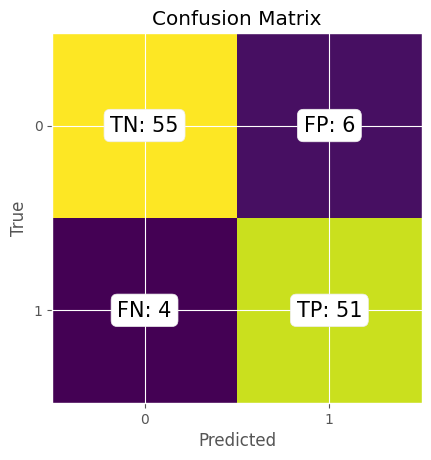

In [93]:
# confusion matrix
confusion = confusion_matrix(y_test, y_pred_rf)

plt.figure()
plt.imshow(confusion, cmap='viridis') 

tick_locs = np.arange(2)
ticks = ['{}'.format(i) for i in range(0, 2)]

plt.xticks(tick_locs, ticks)
plt.yticks(tick_locs, ticks)

plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(2):
    for j in range(2):

        if i == 0 and j == 0:
            lab = 'TN: '
        elif i == 0 and j == 1:
            lab = 'FP: '
        elif i == 1 and j == 0:
            lab = 'FN: '
        else:
            lab = 'TP: '


        plt.text(j, i, lab+str(confusion[i, j]), ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle="round", fc="w"))

plt.title('Confusion Matrix')
plt.show()

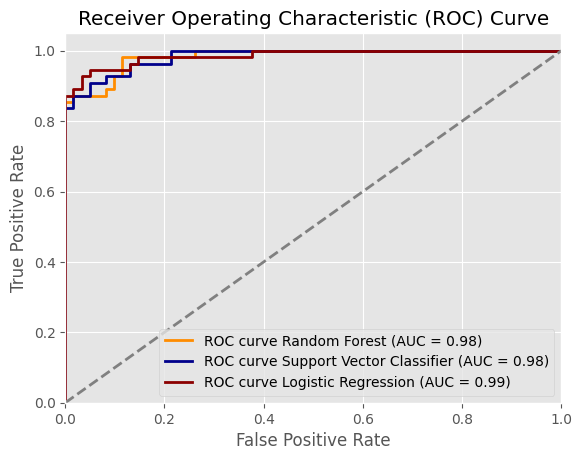

In [94]:
# ROC
fpr_ts, tpr_ts, thresholds_ts = roc_curve(y_test, probs_rf[:, 1])

# AUC
roc_auc_ts = roc_auc_score(y_test, probs_rf[:, 1])


# plot ROC curve
plt.figure()
# Random Forecast Classifier
plt.plot(fpr_ts, tpr_ts, color='darkorange', lw=2, label=f'ROC curve Random Forest (AUC = {roc_auc_ts:.2f})')

# SVC
plt.plot(fpr_svm, tpr_svm, color='darkblue', lw=2, label=f'ROC curve Support Vector Classifier (AUC = {roc_auc_svm:.2f})')

# logistic regression with reducted feats
# plt.plot(fpr_reduced, tpr_reduced, color='darkgreen', lw=2, label=f'ROC curve logistic regression with reducted feats (AUC = {auc_reduced:.2f})')

# first logistic regression
plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve Logistic Regression (AUC = {roc_auc:.2f})') 

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()